In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, LeakyReLU, \
                                    BatchNormalization, Reshape, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from tqdm import tqdm_notebook

In [2]:
tf.enable_eager_execution()

First, we will prepare (real data)

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
X = np.concatenate((X_train, X_test), axis=0).astype(np.float32)
print(X.shape)

(70000, 28, 28)


In [5]:
X = (X - 127.5) / 255.
X = np.expand_dims(X, axis=-1)
print(X.shape)

(70000, 28, 28, 1)


Seems our (real data) is ready

Let's focus on making the generator and discriminator for our GAN

In [6]:
z_dim = 200

In [7]:
def build_generator():
    
    model = Sequential()
    model.add( Dense(7 * 7 * 256, input_shape=(z_dim, )) )
    model.add( Reshape((7, 7, 256)) )
    assert model.output_shape[1:] == (7, 7, 256)
    
    model.add( Conv2DTranspose(128, kernel_size=3, strides=2, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    assert model.output_shape[1:] == (14, 14, 128)
    
    model.add( Conv2DTranspose(64, kernel_size=3, strides=1, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    assert model.output_shape[1:] == (14, 14, 64)
    
    model.add( Conv2DTranspose(1, kernel_size=3, strides=2, padding='same') )
    model.add( Activation('tanh') )
    assert model.output_shape[1:] == (28, 28, 1)
    
    return model

In [8]:
def build_discriminator():
    
    model = Sequential()
    model.add( Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    assert model.output_shape[1:] == (14, 14, 32)
    
    model.add( Conv2D(64, kernel_size=3, strides=2, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    assert model.output_shape[1:] == (7, 7, 64)
    
    model.add( Conv2D(128, kernel_size=3, strides=2, padding='same') )
    model.add( BatchNormalization() )
    model.add( LeakyReLU(alpha=0.05) )
    
    model.add( Flatten() )
    model.add( Dense(1, activation='sigmoid') )
    return model

In [9]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    model.add( generator )
    model.add( discriminator )
    return model

In [10]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator()
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
print('GENERATOR')
print(generator.summary())

GENERATOR
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             2521344   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 14, 14, 64)        256       


In [12]:
print('DISCRIMINATOR')
print(discriminator.summary())

DISCRIMINATOR
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856  

In [13]:
print('GAN')
print(gan.summary())

GAN
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2891521   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 95617     
Total params: 2,987,138
Trainable params: 2,891,137
Non-trainable params: 96,001
_________________________________________________________________
None


This is the most important piece of code. We do the following:-

We make a discriminator, compile it for use. Now, we use the untrainable version of the same discriminator (with same weights) in the gan. SO, for gan, only generator is trainable

In [14]:
z_sample = np.random.normal(size=(2, z_dim)).astype(np.float32)
gen_imgs = generator.predict(z_sample)
discriminator_output = discriminator(gen_imgs)

In [15]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

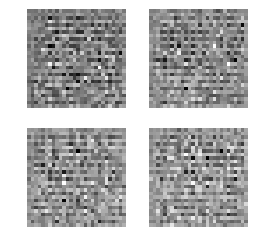

In [16]:
sample_images(generator, image_grid_rows=2, image_grid_columns=2)

In [27]:
gen_losses = []

disc_losses = []
disc_accuracies = []

In [31]:
def train(num_epochs=100, batch_size=32):
    
    real = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))
    
    num_imgs = X.shape[0]
    
    for epoch in range(num_epochs):
        
        num_batches = num_imgs // batch_size
        
        batch_gen_loss = []
        batch_disc_loss = []
        batch_disc_acc = []
        
        for i in tqdm_notebook(range(num_batches)):
        
            idxs = np.random.randint(low=0, high=num_imgs, size=batch_size)
            real_imgs = X[idxs]

            z = np.random.normal(size=(batch_size, z_dim)).astype(np.float32)
            gen_imgs = generator(z)

            d_loss1, d_acc1 = discriminator.train_on_batch(real_imgs, real)
            d_loss2, d_acc2 = discriminator.train_on_batch(gen_imgs, fake)
            d_loss, d_acc = 0.5 * (d_loss1 + d_loss2), 0.5 * (d_acc1 + d_acc2)

            g_loss = gan.train_on_batch(z, real)

            batch_gen_loss.append(g_loss)
            batch_disc_loss.append(d_loss)
            batch_disc_acc.append(d_acc)
        
        print('Epoch {}, generator loss = {}, discriminator loss/acc = {}/{}'.format(
            epoch, np.mean(batch_gen_loss), np.mean(batch_disc_loss), np.mean(batch_disc_acc)*100.))
        sample_images(generator, image_grid_rows=3, image_grid_columns=3)
        
        gen_losses.append( np.mean(batch_gen_loss) )
        disc_losses.append( np.mean(batch_disc_loss) )
        disc_accuracies.append( np.mean(batch_disc_acc) )

In [ ]:
train(batch_size=2)


Epoch 0, generator loss = 4.175047874450684, discriminator loss/acc = 0.19669966030130562/92.11142857142856



Epoch 1, generator loss = 3.8563804626464844, discriminator loss/acc = 0.1917767996225442/92.31714285714285



Epoch 2, generator loss = 3.6968283653259277, discriminator loss/acc = 0.1837546321002801/92.71714285714285
